SKETCH TO IMAGE PROJECT AVEC PYTORCH
-------------------------

Notre projet consiste à utiliser les auto encodeurs pour obtenir des images à partir de dessins (des formes tracées à l'aide d'un crayon). La force des auto-encodeurs, s'il sont bien régularisés, est qu'ils sont capables de procurer des images en sortie cohérentes avec des images fournies en entrée. Pour ce faire les auto-encodeurs utilisent deux outils principaux:

- L'encodeur: Qui permet de transformer les images en variables latentes (exemple: des logits),
- Le décodeur: Qui permet de transformer les variables latentes en images.

Ainsi notre but sera de faire en sorte que les variables latentes soit entièrement régularisées, autrement dit que chaque variable puissent décrire correctement les images fournies en entrées, pour qu'on puisse ensuite comparer les images fournies en sortie aux vraies images grâce à une fonction de perte (voire deux pour obtenir plus de précision). 

![image_autoencoder](https://miro.medium.com/max/828/1*qFzKC1GqOR17XaiQBex83w.webp)

Comme on le voit sur l'image ci-dessus, nous pouvons utiliser comme fonction de perte la moyenne de la somme des différences au carré entre les images obtenues en sortie et les vraies images. 

#### Loss function 

Pour ce projet nous allons utiliser la métrique **SSIM** (pour *Structural Similarity Index*) qui est une fonction de perte initialement créée pour comparer deux images. 

[torchmetrics_structural_similarity](https://torchmetrics.readthedocs.io/en/stable/image/structural_similarity.html)

Le papier original expliquant la théorie derrière cette métrique est téléchargeable à partir de ce lien [Image Quality Assessment: From Error Visibility to Structural Similarity](https://www.cns.nyu.edu/pub/eero/wang03-reprint.pdf).

Et une article plus simple sur medium est disponible sur ce lien [All about Structural Similarity Index](https://medium.com/srm-mic/all-about-structural-similarity-index-ssim-theory-code-in-pytorch-6551b455541e)

SSIM architecture:

![arthictecture_ssim](https://miro.medium.com/max/828/1*SBVkh54RJZrMsozG-vQdCQ.webp)

Le système du **SSIM** nous permet de comparer deux images en nous fournissant des valeurs dans l'intervalle $[-1, 1]$: -1 pour des images complètement différentes et 1 pour des images très semblables. Il est préférable d'utiliser les valeurs normalisées dont l'intervalle est la suivante $[0, 1]$. 

**Remarque importante**: Nous souhaitons obtenir une valeur proche de 1 pour le **SSIM**, seulement l'optimiseur de *pytorch* va essayer de diminuer la valeur en sortie donc nous allons utiliser à la place le résultat obtenu après la modification suivante:
$$
Loss = 1 - SSIM
$$

Ainsi on va maximiser *la mesure de similarité*.

Il est possible d'utiliser la fonction de perte pré-implémentée en python avec la librairie `piqa` que nous allons installer.

In [ ]:
!pip install piqa

#### Contexte

Dans ce projet, nous allons traiter deux types d'images:

- En entrée: Les 'rendered sketch' (données en format svg ou png) qui sont les dessins des objets (**Grayscale**). Lien pour télécharger -> [sketch_link](https://drive.google.com/file/d/1_AIxKnZXQms5Ezb-cEeVIDIoVG-eliHc/view)
- En sortie: Les 'sketch' (données en format png) qui sont les images originaux en **RGB**. 

Pour la récupération du premier type d'image nous pouvons utiliser une librairie (`svglib`) capable de traiter les images en format `svg`.

In [5]:
# installation de la librairie
!pip install svglib

     ------------------------------------ 913.9/913.9 kB 373.3 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 2.3/2.3 MB 267.4 kB/s eta 0:00:00
     ---------------------------------------- 3.8/3.8 MB 324.1 kB/s eta 0:00:00
  Using cached webencodings-0.5.1-py2.py3-none-any.whl (11 kB)
  Created wheel for svglib: filename=svglib-1.5.1-py3-none-any.whl size=30928 sha256=76341ff6c7b734d21db94aadd5eb9edab9713f0a2ed188ed9853710ea8d52c1e
  Stored in directory: c:\users\oumar kane\appdata\local\pip\cache\wheels\0d\01\86\44e257e6f677ffa5d3b64609b443f275faf92428f4256aca85
Successfully built svglib



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Nous allons afficher la première image pour avoir une première appercu.

In [7]:
# importation de la librairie
from svglib.svglib import svg2rlg

# importation de la première image
img1 = svg2rlg("sketch_to_image/data/sketch/00000001_01.svg")

Cependant il est plus facile de travailler avec des images en format `png`. Nous pouvons charger les images disponibles en trois différentes tailles. Nous pouvons visualiser ci-dessus les feuilles de notre arborescence de répertoires.

In [2]:
!tree

Structure du dossier pour le volume Expansion
Le num�ro de s�rie du volume est 6214-BED9
D:.
+---.vscode
+---sketch_to_image
�   +---data
�       +---list
�       +---sketch
�       +---sketch-rendered
�       �   +---width-1
�       �   +---width-3
�       �   +---width-5
�       +---image
+---image


- with-1: Contient les dessins tracées en plus petite taille.
- width-2: Contient les dessins tracées en taille moyenne.
- width-3: Contient les dessins tracées en grande taille.

Utilisons la librairie `PIL` pour charger les images qui sont en la taille que nous considérons la plus adéquate. Ici nous pouvons prendre la taille moyenne pour une précision adéquate.

In [3]:
# importation de la librairie pour le chargement d'un dessin en format png
from PIL import Image

# chargement de l'image numéro 1
img2 = Image.open("sketch_to_image/data/sketch-rendered/width-3/00000001_01.png")

Visualisons l'image récupérée.

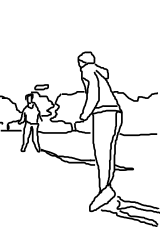

In [4]:
img2

**Interprétation de l'image**: Nous pouvons voir clairement une personne lancer un frisbee à une autre personne qui s'avère être un enfant. Dérrière nous remarquons qu'il y a des arbres. Les vêtements sont également bien tracés ainsi que les ombres.

Pour visualiser l'image en plus clair nous allons devoir télécharger l'autre type de format pour nos images. Un fichier python, déjà implémenté, va être executé pour la récupération des images réelles (en RGB). Nous allons modifier le chemin vers le fichier csv contenant les métadonnées à 'sketch_to_image/imagemeta.csv' (aulieu de 'imagemeta.csv') pour pouvoir le lancer sans erreur. On modifiera également le dossier de destination à 'sketch_to_image/data/image' (aulieu de 'image'). Les modifications se feront au niveau du fichier python [get_images.py](sketch_to_image/get_images.py).

In [ ]:
# # lancement du fichier de récupération des images RGB
# !python sketch_to_image/get_images.py

Visualisons la première image.

In [6]:
# importation de l'image
img2_rgb = Image.open("sketch_to_image/data/image/00000001.jpg")

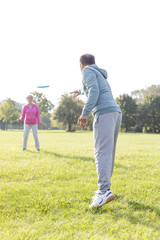

In [8]:
# visualisation de l'image en format rgb
img2_rgb

Oups 😄! Il semble que ce soit une grande femme qui réceptionne le frisbee. Mais en fin de compte nous voyons plus clairement de quoi il s'agît. Ce sera notre but pendant ce projet. Rendre les dessins plus compréhensibles en fournissant leurs apparences réelles.

#### Etapes du projet

Nous allons suivre les étapes listées dans le fichier [etapes](etapes.ipynb).